In [1]:
import argparse
import os
import sys
import torch
import cv2
import numpy as np
from PIL import Image

from IPython.core import ultratb
sys.excepthook = ultratb.FormattedTB(call_pdb=True)

import pytorch3d
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PerspectiveCameras,
    PointLights, 
    AmbientLights,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRendererWithFragments, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesAtlas,
)


# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")



In [2]:
def np_depth_to_colormap(depth):
    """ depth: [H, W] """
    depth_normalized = np.zeros(depth.shape)

    valid_mask = depth > -0.9 # valid
    if valid_mask.sum() > 0:
        d_valid = depth[valid_mask]
        depth_normalized[valid_mask] = (d_valid - d_valid.min()) / (d_valid.max() - d_valid.min())

        depth_np = (depth_normalized * 255).astype(np.uint8)
        depth_color = cv2.applyColorMap(depth_np, cv2.COLORMAP_JET)
        depth_normalized = depth_normalized
    else:
        print('!!!! No depth projected !!!')
        depth_color = depth_normalized = np.zeros(depth.shape, dtype=np.uint8)
    return depth_color, depth_normalized


def center_normalize_verts(verts):
    print('verts before', verts.max(0)[0], verts.min(0)[0], verts.mean(0))

    """ normalize """
    verts -= verts.mean(0, keepdim=True)
    verts /= verts.max()
    print('normalized', verts.max(0)[0], verts.min(0)[0], verts.mean(0))
    return verts

def load_mesh_multi_texture(obj_filename, normalize_verts=False):
    """load_mesh with multiple texture maps"""

    # Load obj file
    verts, faces, aux = load_obj(obj_filename, device=device,
                                load_textures=True,
                                create_texture_atlas=True,
                                texture_atlas_size=8,
                                texture_wrap=None,
                                )
    atlas = aux.texture_atlas
    
    if normalize_verts:
        verts = center_normalize_verts(verts)

    mesh = Meshes(
        verts=[verts],
        faces=[faces.verts_idx],
        textures=TexturesAtlas(atlas=[atlas]),
    )        

    print('create mesh', mesh)
    
    return mesh


def load_mesh_single_texture(obj_filename, normalize_verts=False):
    mesh = load_objs_as_meshes([obj_filename], device=device)

    verts = mesh.verts_packed()
    faces = mesh.faces_packed()
    textures = mesh.textures

    if normalize_verts:
        verts = center_normalize_verts(verts)
    mesh = Meshes(verts=[verts], faces=[faces], textures=mesh.textures)
    return mesh




def get_normals_from_fragments(meshes, fragments):
    """ https://github.com/facebookresearch/pytorch3d/issues/865 """
    faces = meshes.faces_packed()  # (F, 3)
    vertex_normals = meshes.verts_normals_packed()  # (V, 3)
    faces_normals = vertex_normals[faces]
    ones = torch.ones_like(fragments.bary_coords, device=device)
    pixel_normals = pytorch3d.ops.interpolate_face_attributes(
        fragments.pix_to_face, ones, faces_normals
    )
    return pixel_normals

In [3]:
def setup_renderer(args, camera):
    # Initialize a camera.
    print(camera)
    if camera is not None:
        c2w = torch.inverse(camera['w2c'])
        R, T = c2w[:3, :3], c2w[:3, 3:]

        R = torch.stack([-R[:, 0], -R[:, 1], R[:, 2]], 1) # from RDF to Left-Up-Forward for Rotation

        new_c2w = torch.cat([R, T], 1)
        w2c = torch.linalg.inv(torch.cat((new_c2w, torch.Tensor([[0,0,0,1]])), 0))
        R, T = w2c[:3, :3].permute(1, 0), w2c[:3, 3]
        R = R[None] # batch 1 for rendering
        T = T[None]

        H, W = camera['H'], camera['W']
        H, W = int(H / args.down), int(W / args.down)

        intrinsics = camera['intrinsics'] / args.down

        image_size = ((H, W),)  # (h, w)
        fcl_screen = ((intrinsics[0], intrinsics[1]),)  # fcl_ndc * min(image_size) / 2
        prp_screen = ((intrinsics[2], intrinsics[3]), )  # w / 2 - px_ndc * min(image_size) / 2, h / 2 - py_ndc * min(image_size) / 2
        cameras = PerspectiveCameras(focal_length=fcl_screen, principal_point=prp_screen, in_ndc=False, image_size=image_size, R=R, T=T, device=device)

    elif args.camera_type == 'fovperspective':
        R, T = look_at_view_transform(2.7, 0, 180) 
        cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
        image_size = ((255),) # args.image_size
    else:
        raise Exception("Undefined camera")
    print('Camera R T', R, T)

    # Define the settings for rasterization and shading.
    print(image_size)
    raster_settings = RasterizationSettings(
        image_size=image_size[0],
        blur_radius=0.0, 
        faces_per_pixel=1, 
    )

    lights = AmbientLights(device=device)
    #lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

    rasterizer = MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        )

    # Create a Phong renderer by composing a rasterizer and a shader.
    if args.shader == 'mask':
        shader = pytorch3d.renderer.SoftSilhouetteShader()
        print('Use mask SoftSilhouetteShader shader')
    else:
        shader = SoftPhongShader(
            device=device, 
            cameras=cameras,
            lights=lights
        )

    renderer = MeshRendererWithFragments(
        rasterizer = rasterizer,
        shader=shader
    )
    render_setup =  {'cameras': cameras, 'raster_settings': raster_settings, 'lights': lights,
            'rasterizer': rasterizer, 'renderer': renderer}

    return render_setup

In [4]:

parser = argparse.ArgumentParser()
parser.add_argument('--obj_filename', default='./data_colmap/meshed-delaunay.obj', help='')
parser.add_argument('--colmap_sparse_dir', default='./data_colmap/sparse', help='')
parser.add_argument('--image_dir', default='./data_colmap/images', help='')
parser.add_argument('--save_dir', default='results', help='')
parser.add_argument('--down', default=4, type=float, help='downsample image size')
parser.add_argument('--camera_type', default='perspective', help='')
parser.add_argument('--texture_type', default='single', help='single|multi|')
parser.add_argument('--shader', default='phong', help='phong|mask')
parser.add_argument('--debug', default=False, action='store_true')
parser.add_argument('--normalize_verts', default=False, action='store_true')
args = parser.parse_args({})

save_dir = args.save_dir
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

if args.debug:
    args.obj_filename = os.path.join("./cow_mesh/cow.obj")
    args.camera_type = 'fovperspective'
    cameras = [None] 
else:
    import colmap_utils
    cameras = colmap_utils.read_cameras_from_sparse(args.colmap_sparse_dir)
    args.shader = 'mask'  # model reconstructed by COLMAP does not have texture, render mask instead

if args.texture_type == 'multi':
    # For mesh that has multiple texture maps
    mesh = load_mesh_multi_texture(args.obj_filename, normalize_verts=args.normalize_verts)
elif args.texture_type == 'single':
    mesh = load_mesh_single_texture(args.obj_filename, normalize_verts=args.normalize_verts)
else:
    raise Exception('Unknown texture_type: %s' % args.texture_type)


for i, camera in enumerate(cameras[:1]): # only render the first camera
    render_setup = setup_renderer(args, camera)

    save_name = os.path.basename(args.obj_filename)[:-4] + '_%04d' % i
    renderer = render_setup['renderer']
    images, fragments = renderer(mesh)
    
    """ get the rendered RGB image or mask """
    if args.shader == 'phong':
        image_np = images[0, ..., :3].cpu().numpy()[:, :, ::-1] # BGR
        cv2.imwrite(os.path.join(save_dir, '%s.jpg' % save_name), (image_np * 255).astype(np.uint8))
    elif args.shader == 'mask':
        mask = images[0, ..., 3].cpu().numpy() > 0
        cv2.imwrite(os.path.join(save_dir, '%s_mask.jpg' % save_name), (mask * 255).astype(np.uint8))

    """ obtain depth map """
    depth = fragments.zbuf[0, :, :, 0].cpu().numpy()
    depth_color, depth_normalized = np_depth_to_colormap(depth)
    print('depth', depth.shape)
    cv2.imwrite(os.path.join(save_dir, '%s_depth_color.jpg' % (save_name)), (depth_color).astype(np.uint8))
    cv2.imwrite(os.path.join(save_dir, '%s_depth.jpg' % (save_name)), (depth_normalized*255).astype(np.uint8))

    """ obtain normal map """
    normal = get_normals_from_fragments(mesh, fragments)[0, :, :, 0] # [H,W,3]
    normal = torch.nn.functional.normalize(normal, 2.0, 2) # normalize to unit-vector
    w2c_R = render_setup['cameras'].R[0].permute(0, 1) # 3x3, column-major
    camera_normal = normal @ w2c_R.transpose(0, 1) # from world_normal to camera_normal

    normal = camera_normal.cpu().numpy()
    cv2.imwrite(os.path.join(save_dir, '%s_normal.png' % (save_name)), ((normal+1)/2*255).astype(np.uint8))

    if args.debug:
        cat_results1 = np.concatenate([image_np*255, image_np*255], 1) # repeat the rendered image
    else:
        """ load captured image """
        img_path = os.path.join(args.image_dir, camera['img_name'])
        image = cv2.imread(img_path)
        image = cv2.resize(image, (image.shape[1]//args.down, image.shape[0]//args.down))

        cat_results1 = np.concatenate([image, mask[:, :, None].repeat(3, 2)*255], 1)

    """ save results """
    cat_results2 = np.concatenate([depth_color, (normal+1)/2*255.0], 1)
    cat_results = np.concatenate([cat_results1, cat_results2], 0)
    cv2.imwrite(os.path.join(save_dir, '%s_cat.jpg' % (save_name)), (cat_results).astype(np.uint8))

    print('Saved %s' % os.path.join(save_dir, '%s_cat.jpg' % save_name))



/data/guanying/anaconda3/envs/nerfstudio/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


{'img_name': 'IMG_20221210_112836.jpg', 'intrinsics': array([1567.46842128, 1567.11882971, 1000.        ,  745.5       ]), 'H': 1491, 'W': 2000, 'w2c': tensor([[-0.5214,  0.5889, -0.6175,  0.6818],
        [-0.7234,  0.0787,  0.6859, -3.2761],
        [ 0.4526,  0.8043,  0.3850,  1.9347],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])}
Camera R T tensor([[[ 0.5214,  0.7234,  0.4526],
         [-0.5889, -0.0787,  0.8043],
         [ 0.6175, -0.6859,  0.3850]]]) tensor([[-0.6818,  3.2761,  1.9347]])
((372, 500),)
Use mask SoftSilhouetteShader shader
depth (372, 500)
Saved results/meshed-delaunay_0000_cat.jpg


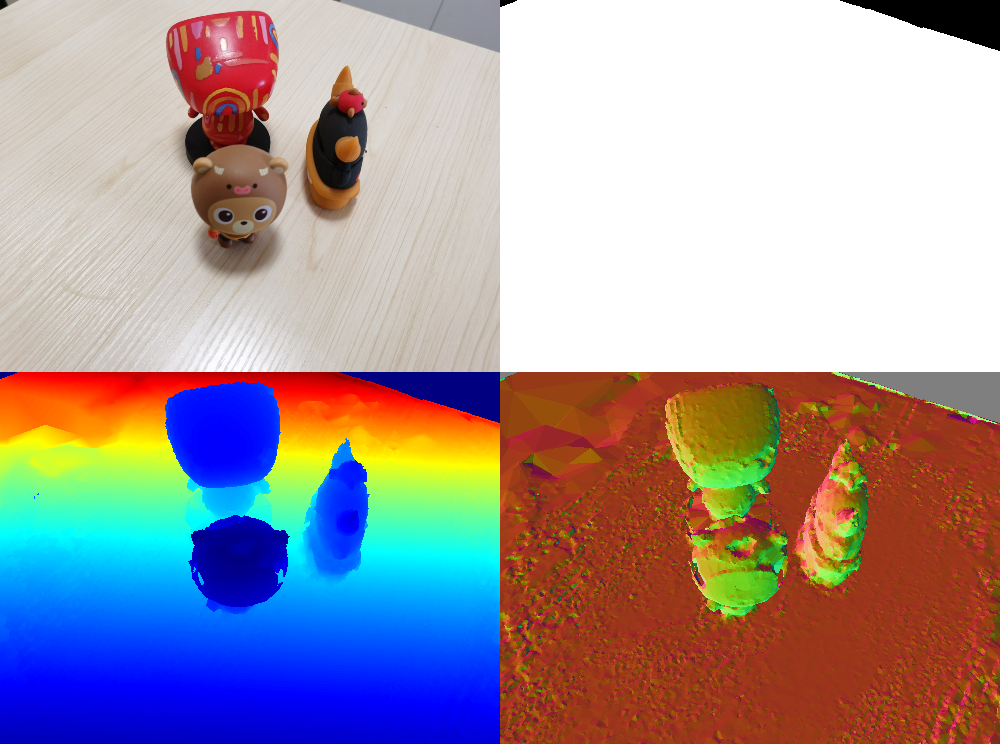

In [5]:
Image.fromarray(cat_results[:,:, ::-1].astype(np.uint8))